In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Circle
from scipy.spatial import HalfspaceIntersection
from linear_gcs import GCSPlanner
from maze import Maze

In [2]:
def draw_region(ax, hs, color):
    pts = hs.intersections
    # order vertices CCW
    c = pts.mean(axis=0)
    ang = np.arctan2(pts[:,1]-c[1], pts[:,0]-c[0])
    verts = pts[np.argsort(ang)]
    ax.add_patch(Polygon(verts, color=color, alpha=0.25))
    ax.plot(*verts.T, color=color, alpha=0.8)
    ax.plot([verts[0,0], verts[-1,0]],
            [verts[0,1], verts[-1,1]],
            color=color, alpha=0.8)

def rectangle_halfspace(xmin, xmax, ymin, ymax):
    hs = np.array([
        [ 1,  0, -xmax],
        [-1,  0,  xmin],
        [ 0,  1, -ymax],
        [ 0, -1,  ymin],
    ])
    center = np.array([(xmin+xmax)/2, (ymin+ymax)/2])
    return HalfspaceIntersection(hs, center)

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Apr 23 07:15:12 PM: Your problem has 33192 variables, 120612 constraints, and 0 parameters.
(CVXPY) Apr 23 07:15:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 23 07:15:13 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 23 07:15:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 23 07:15:13 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 23 07:15:16 PM: Compiling problem (target solver=MOS

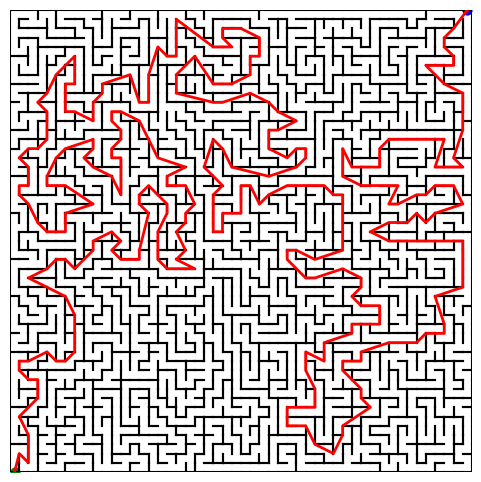

In [ ]:
maze_size   = 50
knock_downs = 2

maze = Maze(maze_size, maze_size)
maze.make_maze()
maze.knock_down_walls(knock_downs)

eps_cell   = 1e-3
regions    = []
cell_index = {}
for i in range(maze_size):
    for j in range(maze_size):
        xmin, xmax = i - eps_cell, i + 1 + eps_cell
        ymin, ymax = j - eps_cell, j + 1 + eps_cell
        cell_index[(i,j)] = len(regions)
        regions.append(rectangle_halfspace(xmin, xmax, ymin, ymax))

# adjacency matrix
n = len(regions)
adj_mat = np.zeros((n+2, n+2), int)
START, GOAL = n, n+1
start = np.array([0.5, 0.0])
goal  = np.array([maze_size-0.5, maze_size])

# (a) cell–cell edges
for (i,j), idx in cell_index.items():
    cell = maze.get_cell(i,j)
    for dir_name, (di,dj) in maze.directions.items():
        if not cell.walls[dir_name]:
            ni, nj = i+di, j+dj
            if 0<=ni<maze_size and 0<=nj<maze_size:
                w = cell_index[(ni,nj)]
                adj_mat[idx,w] = adj_mat[w,idx] = 1

# (b) start/goal cells (clamp into [0,maze_size-1])
sc = (min(int(np.floor(start[0])),maze_size-1),
      min(int(np.floor(start[1])),maze_size-1))
gc = (min(int(np.floor(goal[0])), maze_size-1),
      min(int(np.floor(goal[1])), maze_size-1))
start_cell = cell_index[sc]
goal_cell  = cell_index[gc]

adj_mat[START,   start_cell] = adj_mat[start_cell, START] = 1
adj_mat[GOAL,    goal_cell ] = adj_mat[goal_cell,  GOAL ] = 1

world_bounds = [[0, maze_size], [0, maze_size]]

# ------------------------------------------------------------------
# Plan and plot
# ------------------------------------------------------------------
planner = GCSPlanner(
    halfspace_regions=regions,
    start=start,
    goal=goal,
    world_bounds=world_bounds,
    adj=adj_mat,           # ← pass it here so _skip_overlap=True
    solve_integer=False
)
shortest_path = planner.solve()

planner.adj = adj_mat          # ← this alone does *not* flip the skip flag!
shortest_path = planner.solve()

# Plot exactly like original
fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim(0, maze_size); ax.set_ylim(0, maze_size)
ax.set_aspect("equal"); ax.axis("off")

# draw maze walls
for i in range(maze_size):
    for j in range(maze_size):
        cell = maze.get_cell(i, j)
        xmin, ymin = i, j
        xmax, ymax = i+1, j+1
        if cell.walls['N']: ax.plot([xmin, xmax], [ymax, ymax], 'k-')
        if cell.walls['S']: ax.plot([xmin, xmax], [ymin, ymin], 'k-')
        if cell.walls['W']: ax.plot([xmin, xmin], [ymin, ymax], 'k-')
        if cell.walls['E']: ax.plot([xmax, xmax], [ymin, ymax], 'k-')

# draw GCS solution
if shortest_path:
    sp = np.array(shortest_path)
    ax.plot(sp[:,0], sp[:,1], 'r-', lw=2)
    ax.scatter(*start, c='green', s=40)
    ax.scatter(*goal,  c='blue',  s=40)

plt.show()
